# Diffusion for 256 x 256

In [1]:
import jupyter_black

import sys, os, shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from PIL import Image

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src")

jupyter_black.load()

In [2]:
# Custom modules
from dataset import create_substrate_dataset, get_part_substrates_from_all
from unet import UNet
from diffusion import Diffusion
from utils_diffusion import (
    train,
    count_fid_metric,
    show_grid_samples,
    generate_and_save_samples,
)

In [3]:
# Dirs
sample_dir = "/usr/src/samples_substrate"
substrate_dir = "/usr/src/data/substrates"
part_substrate_dir = "/usr/src/data/part_substrates"

image_size = 256

In [ ]:
# Cut part substrates
get_part_substrates_from_all(
    substrate_dir, part_substrate_dir, part_size=(image_size, image_size)
)

In [4]:
# Settings
channels = 1
batch_size = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create the dataset of substrates
substrate_dataset = create_substrate_dataset(part_substrate_dir)

# Create the dataloader for training
train_loader = DataLoader(substrate_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# Check dataset and trainloader

print(f"Len of dataset:  {len(substrate_dataset)} images")
print(f"Len of trainloader:  {len(train_loader)} batches")
print(f"Shape of batch:  {next(iter(train_loader)).shape}")

Len of dataset:  5400 images
Len of trainloader:  540 batches
Shape of batch:  torch.Size([10, 1, 256, 256])


In [25]:
# Initialization of the diffusion

timesteps = 200
diffusion = Diffusion(timesteps)

In [31]:
# Initialization of the denoising model and optimizer

model = UNet(img_dim=image_size, img_channels=channels)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
# Training model (256x256, 7 epochs, 200 timesteps about 13 minutes on NVIDIA)

epochs = 7
log_path = "logging_substrates"
log_interval = len(train_loader) // 5

loss_progress = train(
    model,
    diffusion,
    timesteps,
    train_loader,
    epochs,
    optimizer,
    device,
    log_path,
    log_interval,
)

----- Epoch 1 -----
Loss: 0.6283411383628845
Loss: 0.007756741251796484
Loss: 0.03950662910938263
Loss: 0.005650498904287815
Loss: 0.0076151760295033455


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 2 -----
Loss: 0.0061674281023442745
Loss: 0.002848721342161298
Loss: 0.002727056387811899
Loss: 0.0062957345508039
Loss: 0.0015991412801668048


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 3 -----
Loss: 0.0030423912685364485
Loss: 0.0059989518485963345
Loss: 0.0030080783180892467
Loss: 0.005802319850772619
Loss: 0.0032967242877930403


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 4 -----
Loss: 0.0016753136878833175
Loss: 0.024058064445853233
Loss: 0.002973171416670084
Loss: 0.006654215045273304
Loss: 0.021225525066256523


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 5 -----
Loss: 0.021558282896876335
Loss: 0.03833303600549698
Loss: 0.010811706073582172
Loss: 0.006968185305595398
Loss: 0.003755297977477312


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 6 -----
Loss: 0.0014071710174903274
Loss: 0.0028018683660775423
Loss: 0.0014303561765700579
Loss: 0.0016666256124153733
Loss: 0.006159074138849974


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

----- Epoch 7 -----
Loss: 0.0014803657541051507
Loss: 0.03591889515519142
Loss: 0.004924727138131857
Loss: 0.004188799764961004
Loss: 0.0020915193017572165


sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Total training time = 786.855 sec


In [33]:
# Save trained model

torch.save(model, f"substrate_ddpm_{timesteps}_steps_{epochs}_epochs.pt")

In [ ]:
# Load pretrained model

# model = torch.load("substrate_ddpm_300_steps_5_epochs.pt")
model = torch.load("substrate_ddpm_200_steps_7_epochs.pt")
model.eval()

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

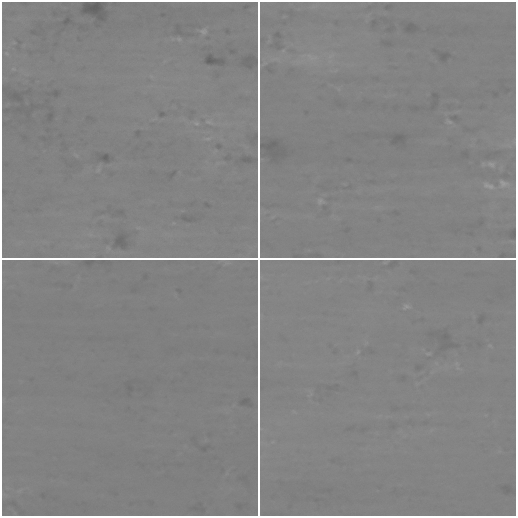

In [34]:
# Create grid of generated samples and show it

n_samples = 4
samples = show_grid_samples(
    n_samples, diffusion, model, image_size, channels, "grid_substrates"
)

In [37]:
# Generate many new separate samples and save them

generate_and_save_samples(sample_dir, 30, 10, diffusion, model, image_size, channels)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [35]:
# Count FID metric

feature = 2048
print(
    f"feature = {feature}, FID =",
    count_fid_metric(
        train_loader, diffusion, model, image_size, channels, 100, feature
    ),
)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

100 samples are generated, time = 143.788 sec
FID is computed, time = 32.033 sec
feature = 2048, FID = tensor(143.3288)
